# Ансамбли моделей машинного обучения

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm, tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier
# from gmdhpy.gmdh import Classifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from operator import itemgetter

In [3]:
wine = load_wine()

In [4]:
df = pd.DataFrame(data= np.c_[wine['data'], wine['target']],
                     columns= wine['feature_names'] + ['target'])

In [5]:
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0.0


In [6]:
# проверим есть ли пропущенные значения
df.isnull().sum()

alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
target                          0
dtype: int64

In [7]:
y = df['target']
X = df.drop('target', axis = 1)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(scaled_data, y, test_size = 0.4, random_state = 1)

### Бэггинг

In [8]:
# Обучим классификатор на 5 деревьях
bc = BaggingClassifier(n_estimators=5, oob_score=True, random_state=10)
bc_prediction = bc.fit(X_train, y_train).predict(X_test)

C:\Users\Huawei\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_bagging.py:789: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn(
C:\Users\Huawei\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_bagging.py:795: RuntimeWarning: invalid value encountered in divide
  oob_decision_function = predictions / predictions.sum(axis=1)[:, np.newaxis]


### Градиентный бустинг

In [9]:
gb = GradientBoostingClassifier(random_state=1)
gb_prediction = gb.fit(X_train, y_train).predict(X_test)

### Стекинг

In [10]:
# Качество отдельных моделей
def val_mae(model):
    st_prediction = model.fit(X_train, y_train).predict(X_test)
    print(model)
    print('Accuracy score={}'.format(accuracy_score(y_test, st_prediction)))

In [11]:
# Точность на отдельных моделях
for model in [
    DecisionTreeClassifier(random_state=1),
    svm.SVC(random_state=1),
    LogisticRegression(random_state=1)
]:
    val_mae(model)
    print('==========================')
    print()

DecisionTreeClassifier(random_state=1)
Accuracy score=0.8472222222222222

SVC(random_state=1)
Accuracy score=1.0

LogisticRegression(random_state=1)
Accuracy score=0.9722222222222222



In [12]:
# Первый уровень - две модели: дерево и метод опорных векторов
# Второй уровень: логистическая регрессия

estimators = [
    ('dt', DecisionTreeClassifier(random_state=1)),
    ('svc', svm.SVC(random_state=1))
]

sc = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)
sc_prediction = sc.fit(X_train, y_train).predict(X_test)

### Оценка качества решений

In [13]:
print("Бэггинг: ", accuracy_score(y_test, bc_prediction))
print("Градиентный бустинг: ", accuracy_score(y_test, gb_prediction))
print("Стекинг (дерево и метод опорных векторов + логистическая регрессия): ", accuracy_score(y_test, sc_prediction))

Бэггинг:  0.9722222222222222
Градиентный бустинг:  0.9722222222222222
Стекинг (дерево и метод опорных векторов + логистическая регрессия):  1.0


Бэггинг:  0.9722222222222222


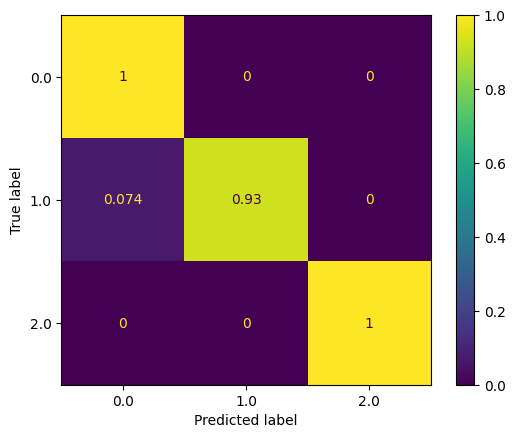

In [14]:
print("Бэггинг: ", accuracy_score(y_test, bc_prediction))

cm = confusion_matrix(y_test, bc_prediction, labels=np.unique(df.target), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(df.target))
disp.plot()

Градиентный бустинг:  0.9722222222222222


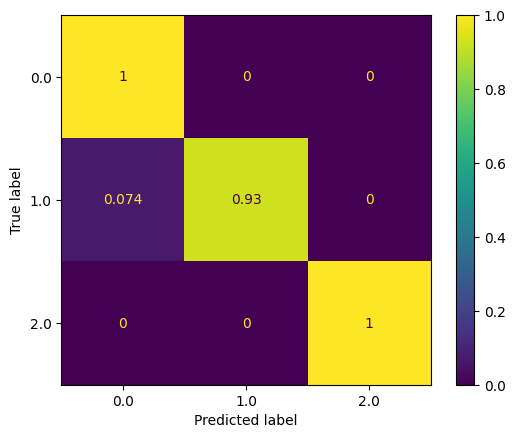

In [15]:
print("Градиентный бустинг: ", accuracy_score(y_test, gb_prediction))

cm = confusion_matrix(y_test, gb_prediction, labels=np.unique(df.target), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(df.target))
disp.plot()

Стекинг (дерево и метод опорных векторов + логистическая регрессия):  1.0


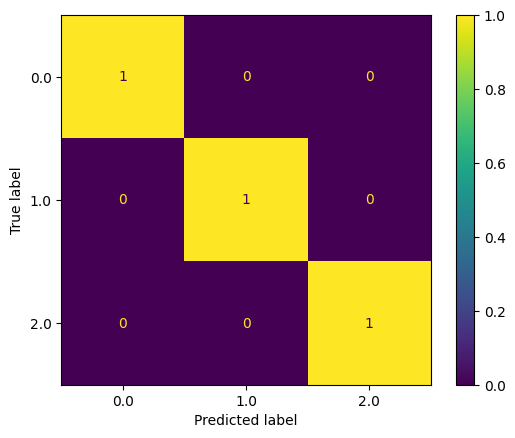

In [16]:
print("Стекинг (дерево и метод опорных векторов + логистическая регрессия): ", accuracy_score(y_test, sc_prediction))

cm = confusion_matrix(y_test, sc_prediction, labels=np.unique(df.target), normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(df.target))
disp.plot()